# Supershoes Causal Inference
## Analysis by Adam Visokay

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
import itertools
from itertools import permutations

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load in the NCAA data we scraped.

In [2]:
df100 = pd.read_csv('tfrrs_scraped.csv')

### Keep only running events.

In [3]:
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']

df100 = df100[df100['EVENT'].isin(running_events)]
df100.dtypes

POSITION        int64
CHAMP_YEAR      int64
DIVISION       object
EVENT          object
SEX            object
ATHLETE        object
YEAR           object
TEAM           object
TIME           object
TIME_SECS     float64
MARK           object
CONV           object
POINTS        float64
MEET           object
MEET DATE      object
dtype: object

In [4]:
df100.head()

,POSITION,CHAMP_YEAR,DIVISION,EVENT,SEX,ATHLETE,YEAR,TEAM,TIME,TIME_SECS,MARK,CONV,POINTS,MEET,MEET DATE
0,1,2021,D1,100,Men,"Laird, Terrance",JR-3,LSU,9:80,9.80,NaN,NaN,NaN,SEC Outdoor Track & Field Championships,"May 13, 2021"
1,2,2021,D1,100,Men,"Maswanganyi, Shaun",FR-1,Houston,9:87,9.87,NaN,NaN,NaN,The American Outdoor Track & Field Championships,"May 14, 2021"
2,3,2021,D1,100,Men,"Martin, JoVaughn",SO-2,Florida State,9:94,9.94,NaN,NaN,NaN,UF Tom Jones Invitational,"Apr 16, 2021"
3,4,2021,D1,100,Men,"Boling, Matthew",FR-1,Georgia,9:97,9.97,NaN,NaN,NaN,SEC Outdoor Track & Field Championships,"May 13, 2021"
4,5,2021,D1,100,Men,"Amoah, Joseph",SR-4,Coppin State,10:00,10.00,NaN,NaN,NaN,2021 Aggie Invitational,"Apr 10, 2021"


### Split into pre and post dataframes

In [5]:
df100 = df100[df100['CHAMP_YEAR'] != 2021]
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]

### Build some query functions for the dataframe.

In [6]:
def query_each_year(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = []
    for year in df.CHAMP_YEAR.unique():
        new_df = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
        results.append(new_df)
    return results

### Plot some histograms to compare results for each year, for given Division, Sex and Event.

In [7]:
# use queried list of dfs for each year to create a histogram for each year

def histograms_each_year(df, division, sex, event):
    '''Creates a histogram for each df in df_list after query constraints'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        fig, ax = plt.subplots()
        plot = df.TIME_SECS.plot(kind='hist', bins=15, ax=ax)
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.gcf().set_size_inches(8,5)
        pl.suptitle(str(df.CHAMP_YEAR.iloc[0]) + ' ' + df.SEX.iloc[0] + '\'s ' + df.EVENT.iloc[0])

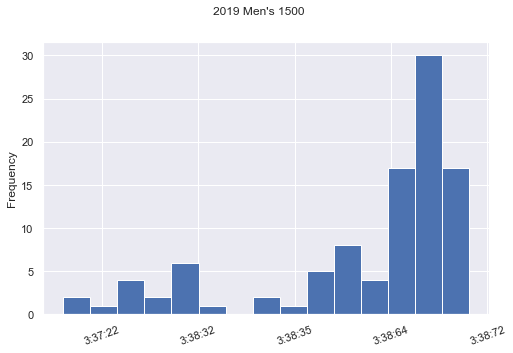

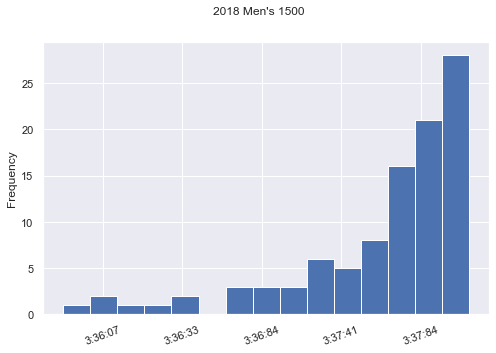

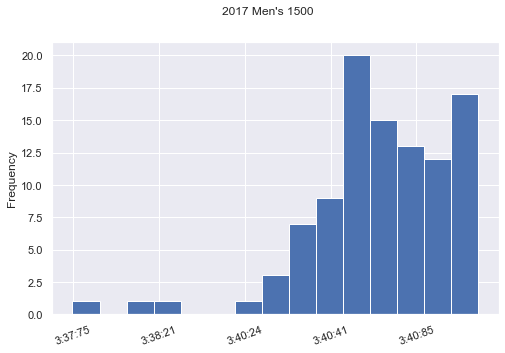

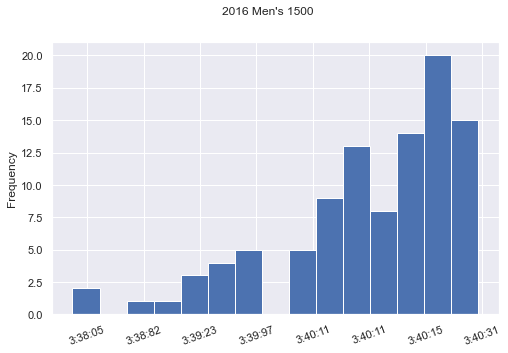

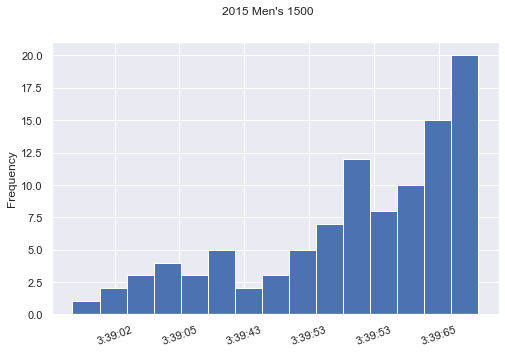

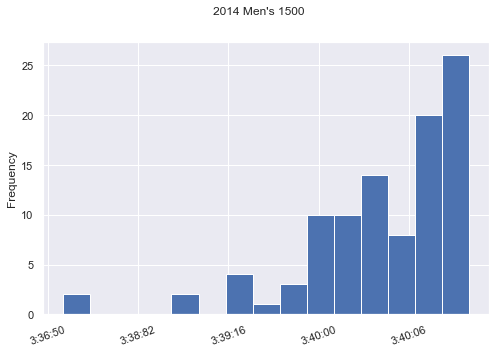

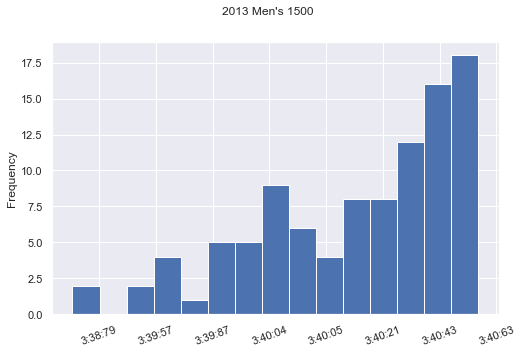

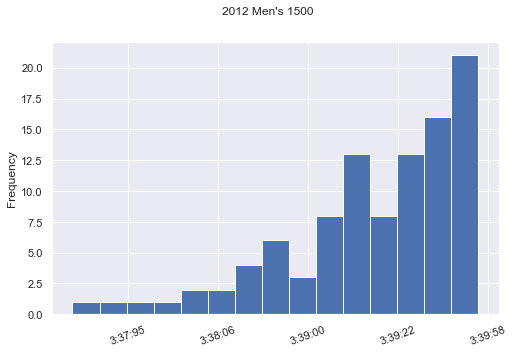

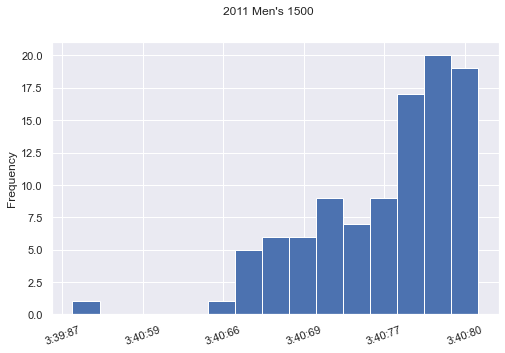

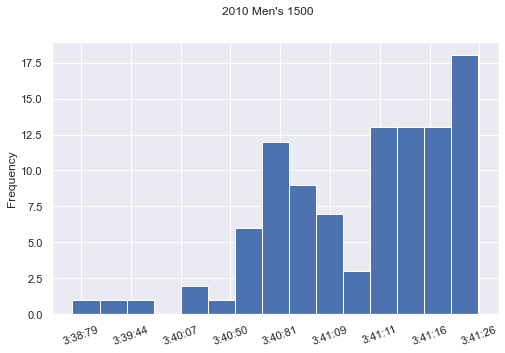

In [8]:
histograms_each_year(df100, 'D1', 'Men', '1500')

### Use an overlapping histogram density plot to compare the distribution over time.

In [9]:
def hist_density_overlap(df, param):
    '''
    Creates an overlapping histogram and density for each df in queried list of dfs for each year
    :param: list of strings ['division', 'sex', 'event'] to be queried
    '''
    division, sex, event = param[0], param[1], param[2]
        
    df_list = query_each_year(df, division, sex, event)
    palette = iter(sns.color_palette("mako", len(df_list)))
    
    for df in df_list:
        plot = sns.distplot(df.TIME_SECS, kde=True, bins=15, hist=True, label=df.CHAMP_YEAR.iloc[0], color = next(palette))
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        
        plt.legend()
        plt.gcf().set_size_inches(20,12)

        plt.xlim(reversed(plt.xlim()))

        pl.suptitle(division + ' ' + sex + '\'s ' + event)
#         plt.savefig(f"overlapping_histograms_{division}_{sex}_{event}.png")

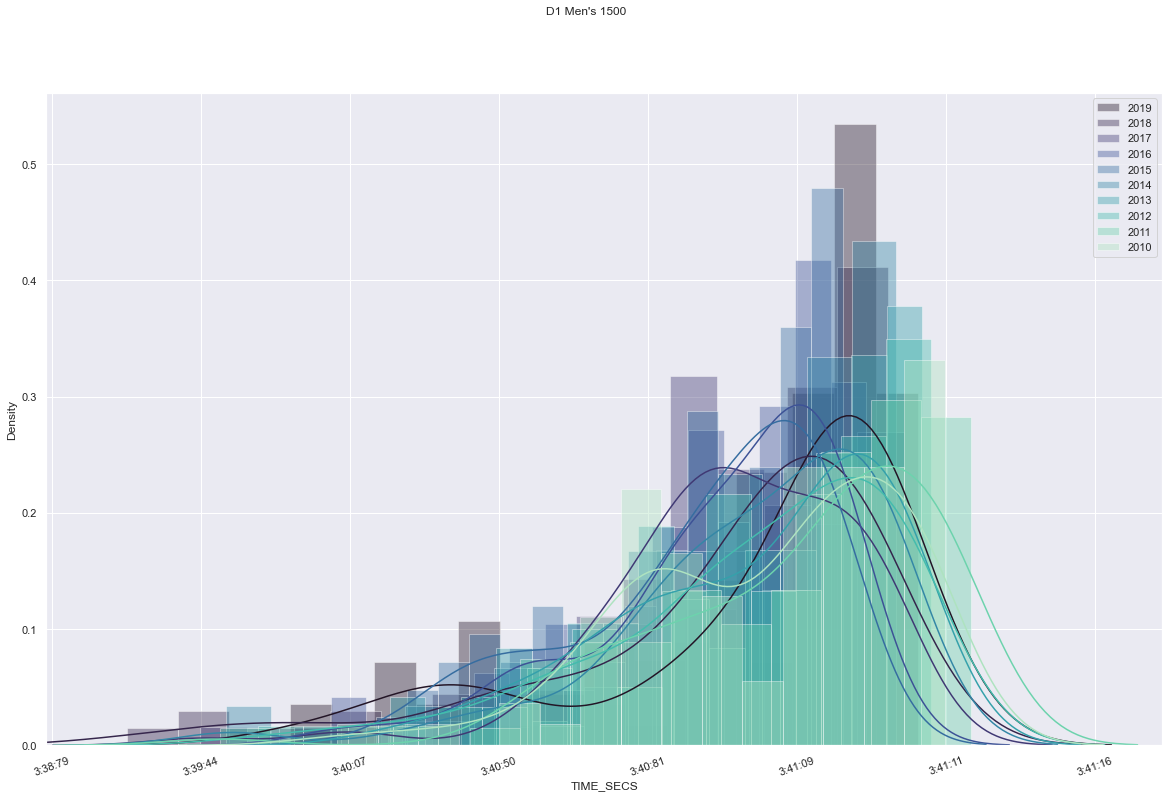

In [10]:
hist_density_overlap(df100, ['D1', 'Men', '1500'])

### Split df into pre-post 2021

In [11]:
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100 = df100[df100['CHAMP_YEAR'] != 2021]

In [12]:
# function to convert seconds to time format
def convert_seconds(secs):
    '''Takes a total number of seconds and returns in %M:%S.%f format'''
    date = datetime.datetime.utcfromtimestamp(secs)
    output = datetime.datetime.strftime(date, "%M:%S.%f")
    return output

### Group by distance/sprint and run t-test to see if slopes are statistically different.

In [13]:
# new dfs for dist/sprints with log time secs to use for slope comparison
distance_events = ['800', '10000', '1500', '3000S','5000']
dist_df = df100[df100['EVENT'].isin(distance_events)]
sprint_df = df100[~df100['EVENT'].isin(distance_events)]

In [14]:
def regroup_df(df):
    '''group by CHAMP_YEAR DIVISION EVENT SEX'''
    df_group = df.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']).mean()
    group = df_group['TIME_SECS'].groupby(['EVENT', 'DIVISION'], group_keys=False)
    res = group.apply(lambda x: x.sort_values(ascending=[False]))
    
    return pd.DataFrame(res).reset_index()

In [15]:
dist_df = regroup_df(dist_df)
sprint_df = regroup_df(sprint_df)

### Regression for time trends

In [16]:
# functions to get the slope, coef of determination, pvalue and std errors for two arrays
def reg_slope(X,y):
    '''Return slope for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[0]

def reg_rval(X,y):
    '''Return p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[2]

def reg_pval(X,y):
    '''Return slope for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[3]

def reg_stderr(X,y):
    '''Return standard error for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[4]

### Function that produces a table of regression results to compare distance with sprinting.

In [17]:
def reg_table(df):
    '''Take top 10 rows of dataframe: regress TIME_SECS on CHAMP_YEAR, predict 2021 and save the results to new df.'''
    results_list = []
    while len(df) > 0:
        
        years = [df.CHAMP_YEAR[i] for i in range(10)]
        means = [df.TIME_SECS[i] for i in range(10)]
        
        slope = reg_slope(years,means)
        rval = reg_rval(years,means)
        pval = reg_pval(years,means)
        std_err = reg_stderr(years,means)
        
        X = np.array(years).reshape(-1, 1)
        y = means

        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.array(2021).reshape(-1,1))[0]
        
        

        row_result = [str(df.DIVISION[0]), str(df.SEX[0]), str(df.EVENT[0]), slope, rval, pval, std_err, pred]
        results_list.append(row_result)
        
        df = df.drop(range(0,10))
        df = df.reset_index(drop=True)
    return pd.DataFrame(results_list, columns=['DIVISION', 'SEX', 'EVENT', 'SLOPE', 'R_VAL','P_VAL', 'STD_ERR', '2021_PRED'])

In [18]:
# create prediction intervals 

def pred_interval(means_list, prediction, critical_value = 1.96):
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)

In [53]:
# create regression tables and desc df
sprint_results = reg_table(sprint_df)
dist_results = reg_table(dist_df)
sprint_slopes = sprint_results.SLOPE.describe()
dist_slopes = dist_results.SLOPE.describe()

dist_results['EVENT_TYPE'] = 'DISTANCE'
sprint_results['EVENT_TYPE'] = 'SPRINT'

desc = pd.concat([sprint_slopes, dist_slopes], axis=1)
desc.columns = ['Sprint Slopes', 'Distance Slopes']
desc

,Sprint Slopes,Distance Slopes
count,42.000000,30.000000
mean,-0.061954,-0.899058
std,0.060964,1.031908
min,-0.247818,-3.958124
25%,-0.078691,-1.258297
50%,-0.038169,-0.402721
75%,-0.024698,-0.158856
max,-0.007778,-0.023085


### Plot the distribution of the slopes for sprinting vs distance

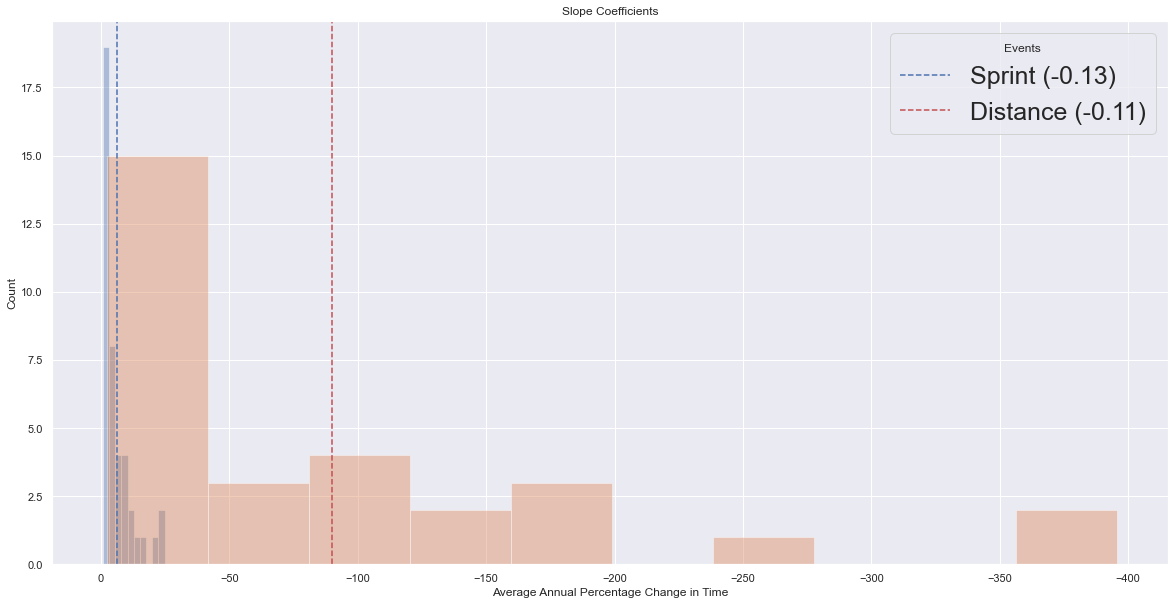

In [54]:
# plot the distribution of the slopes for sprinting vs distance
plt.hist(sprint_results['SLOPE']*100, alpha=0.4)
plt.hist(dist_results['SLOPE']*100, alpha=0.4)
plt.title('Slope Coefficients')
plt.xlabel('Average Annual Percentage Change in Time')
plt.ylabel('Count')
plt.axvline(x=sprint_results.SLOPE.mean()*100, color='b', linestyle = '--')
plt.axvline(x=dist_results.SLOPE.mean()*100, color='r', linestyle = '--', label='Treatment')
plt.gca().invert_xaxis()
plt.legend(['Sprint (-0.13)', 'Distance (-0.11)'], loc='upper right', title='Events', prop={'size': 25})
plt.show()

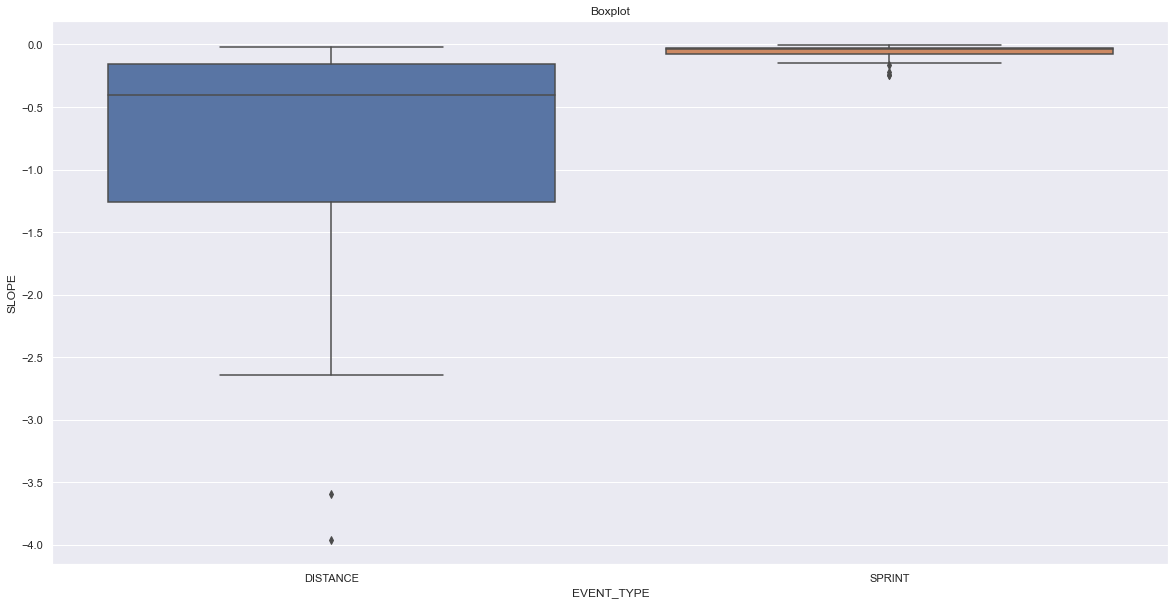

In [60]:
sns.boxplot(data=slopes_df, x='EVENT_TYPE', y='SLOPE');
plt.title("Boxplot");

### Create unweighted combination for sprinting and distance events. 

In [21]:
# start from original data
df100 = pd.read_csv('tfrrs_scraped.csv')

# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

# df100 = df100[df100['DIVISION'].isin(['D1', 'D2'])]

# list of groups and avg time_secs
avg_list = []
for group in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']):
    avg_list.append([group[0], group[1].TIME_SECS.mean()])
    
# split group tuple back into year/division/event/sex columns and drop group tuple
df_grouped = pd.DataFrame(avg_list, columns = ['GROUP', 'TIME_SECS_AVG'])
df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(df_grouped['GROUP'].tolist(), index=df_grouped.index)
df_grouped = df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX', 'TIME_SECS_AVG']]

In [22]:
# list of dfs for each division/event/sex group
df_list = [group[1].reset_index() for group in df_grouped.groupby(['DIVISION', 'EVENT', 'SEX'])]

# for each df, rescale the TIME_SECS column by dividing all by the 2010 avg
avg_2010 = [df['TIME_SECS_AVG'][0] for df in df_list]
for df,avg in zip(df_list,avg_2010):
    df['TIME_SECS_SCALED'] = df['TIME_SECS_AVG']/avg
    
# concat back into one df
df_scaled = pd.concat(df_list).reset_index()
df_scaled.drop(['level_0','index'], axis=1, inplace=True)

In [23]:
# add treat, after and treatafter variable to the df
distance = ['800', '1500', '5000', '10000', '3000S']
treat_list = [1 if event in distance else 0 for event in df_scaled['EVENT']]
df_scaled['TREAT'] = treat_list
df_scaled['AFTER'] = df_scaled['CHAMP_YEAR'] >= 2021
df_scaled['TREAT_AFTER'] = df_scaled['AFTER']*df_scaled['TREAT']

In [24]:
# create synthetic control for 2010-2019, non weighted scaled average for each year for non-treated groups
control_df = df_scaled[(df_scaled['TREAT'] == 0) & (df_scaled['CHAMP_YEAR'] < 2021)]

sc = pd.DataFrame([[group[0], group[1]['TIME_SECS_SCALED'].mean()] for group in control_df.groupby('CHAMP_YEAR')], columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

In [25]:
# run log transformed regression to predict
xs = np.array(sc.CHAMP_YEAR).reshape(-1, 1)
log_ys = [np.log(x) for x in sc.AVG_SCALED_SECS]

reg = LinearRegression().fit(xs, log_ys)
pred = np.exp(reg.predict(np.array(2021).reshape(-1,1))[0])

sc = sc.append({'CHAMP_YEAR':2021, 'AVG_SCALED_SECS':pred}, ignore_index=True)
sc['CHAMP_YEAR'] = sc['CHAMP_YEAR'].astype(int)
print(sc)

    CHAMP_YEAR  AVG_SCALED_SECS
0         2010         1.000000
1         2011         0.995248
2         2012         0.992034
3         2013         0.993213
4         2014         0.991738
5         2015         0.989422
6         2016         0.988564
7         2017         0.987030
8         2018         0.987340
9         2019         0.987927
10        2021         0.983199


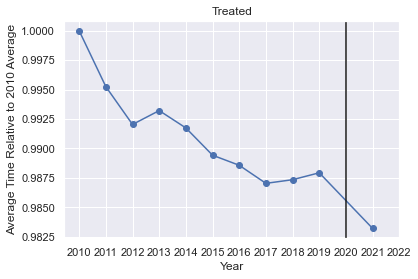

In [26]:
plt.plot(sc.CHAMP_YEAR, sc.AVG_SCALED_SECS, '-o');
plt.axvline(x=2020, color = 'k')
plt.title('Treated')
plt.xticks([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
plt.xlabel('Year')
plt.ylabel('Average Time Relative to 2010 Average')
plt.show()

In [27]:
#create list of dfs for treated groups and control groups
treat_df = df_scaled[df_scaled['TREAT'] == 1]
control_df = df_scaled[df_scaled['TREAT'] == 0]

treat_list = [group[1] for group in treat_df.groupby(['DIVISION', 'EVENT', 'SEX'])]
control_list = [group[1] for group in control_df.groupby(['DIVISION', 'EVENT', 'SEX'])]

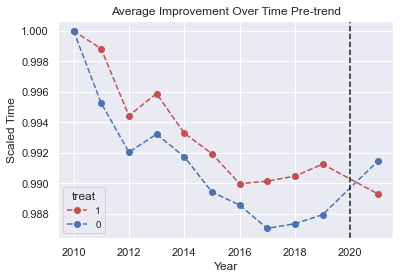

In [28]:
# plot scaled trends for synthetic control and averaged treated for pre-2021
t = []
c = []

for group in treat_df.groupby('CHAMP_YEAR'):
    t.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

for group in control_df.groupby('CHAMP_YEAR'):
    c.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

t_df = pd.DataFrame(t, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])
c_df = pd.DataFrame(c, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

treat = plt.plot(t_df['CHAMP_YEAR'], t_df['AVG_SCALED_SECS'], '--o', color='r')
control = plt.plot(c_df['CHAMP_YEAR'], c_df['AVG_SCALED_SECS'], '--o', color='b')
plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time Pre-trend')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
plt.legend([1,0], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

In [29]:
#update all 2021 values of TIME_SECS_SCALED with prediction from SC

df_scaled_SC = df_scaled.copy()

# df_scaled_SC.loc[df_scaled_SC.CHAMP_YEAR == 2021, 'TIME_SECS_SCALED'] = pred

In [30]:
#Model the DiD specification with SC Observed

X = sm.add_constant(df_scaled[['TREAT', 'TREAT_AFTER', 'AFTER']].astype('float'))
y = df_scaled['TIME_SECS_SCALED']

smf_fit = smf.ols('TIME_SECS_SCALED ~ 1 + TREAT + TREAT_AFTER + AFTER', df_scaled).fit()

print(smf_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       TIME_SECS_SCALED   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     9.388
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           4.22e-06
Time:                        13:26:16   Log-Likelihood:                 2849.2
No. Observations:                 792   AIC:                            -5690.
Df Residuals:                     788   BIC:                            -5672.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9913      0.000   3057.093

In [31]:
effect = -0.0045
results = []
for group in df_scaled.groupby(['DIVISION', 'EVENT', 'SEX']):
    if group[0][1] in distance:
        group[1].reset_index(inplace=True)
        results.append([group[0], effect*group[1]['TIME_SECS_AVG'][0]])
        
results = pd.DataFrame(results, columns=['GROUP', 'SECONDS_FASTER'])
results['SECONDS_FASTER'] = results['SECONDS_FASTER']*(-1)
results[['DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(results['GROUP'].tolist(), index=results.index)
results = results[['DIVISION', 'EVENT', 'SEX', 'SECONDS_FASTER']]

# range of average improvement depending on DIVISION/SEX for each event
results = results.groupby(['EVENT']).agg({'SECONDS_FASTER': [np.min,np.max]}).sort_values('EVENT', ascending=False)
results

SECONDS_FASTER           
                amin       amax
EVENT                          
800         0.490252   0.606585
5000        3.752308   4.765761
3000S       2.402869   3.060077
1500        1.006378   1.258681
10000       7.913150  10.148347